In [421]:
from pathlib import Path
from IPython.core.debugger import set_trace
import pickle, gzip, math, torch, matplotlib as mpl
import matplotlib.pyplot as plt
from torch import tensor

# **Some stuff I think I must understand**

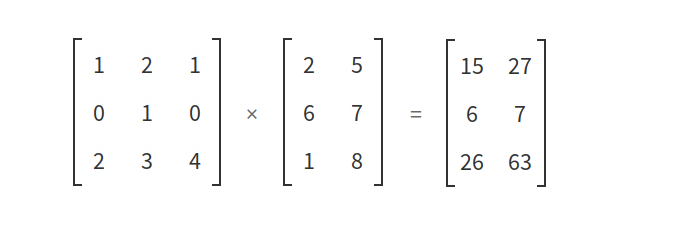

In [422]:
weights = None

In [423]:
m1 = torch.tensor([[1,2,1],[0,1,0],[2,3,4]])
m2 = torch.tensor([[2,5],[6,7],[1,8]])
m1,m1.shape,m2,m2.shape

(tensor([[1, 2, 1],
         [0, 1, 0],
         [2, 3, 4]]),
 torch.Size([3, 3]),
 tensor([[2, 5],
         [6, 7],
         [1, 8]]),
 torch.Size([3, 2]))

___
### **Three loops**
___

In [424]:
def matmul(a,b):
    ar,ac = a.shape # n_rows * n_cols
    br,bc = b.shape
    assert ac==br
    c = torch.zeros(ar, bc)
    for i in range(ar):
        for j in range(bc):
            for k in range(ac): # or br
                c[i,j] += a[i,k] * b[k,j]
    return c

In [425]:
matmul(m1,m2)

tensor([[15., 27.],
        [ 6.,  7.],
        [26., 63.]])

___
### **Removing the innermost loop**

In [426]:
def matmul(a,b):
    ar,ac = a.shape
    br,bc = b.shape
    assert ac==br
    c = torch.zeros(ar, bc)
    for i in range(ar):
        for j in range(bc):
            # Any trailing ",:" can be removed
            c[i,j] = (a[i,:] * b[:,j]).sum()
    return c

In [427]:
matmul(m1,m2)

tensor([[15., 27.],
        [ 6.,  7.],
        [26., 63.]])

___
### **This is how broadcasting works**

In [428]:
def matmul(a,b):
    ar,ac = a.shape
    br,bc = b.shape
    assert ac==br
    c = torch.zeros(ar, bc)
    for i in range(ar):
#       c[i,j] = (a[i,:]          * b[:,j]).sum() # previous
        c[i]   = (a[i  ].unsqueeze(-1) * b).sum(dim=0)
    return c

In [429]:
matmul(m1,m2)

tensor([[15., 27.],
        [ 6.,  7.],
        [26., 63.]])

here `m1[0].unsqueeze(-1)` makes the shape of the m[0] -> torch.Size([3, 1]) so it broadcasts on m2 according to Broadcasting rules.(second dimension is 1)

*one of them is 1, in which case that dimension is broadcasted to make it the same size*

In [430]:
(m1[0]), (m1[0].unsqueeze(-1)*m2),(m1[0].unsqueeze(-1)*m2).sum(dim=0),(m1[0].unsqueeze(-1)*m2).sum(dim=1)

(tensor([1, 2, 1]),
 tensor([[ 2,  5],
         [12, 14],
         [ 1,  8]]),
 tensor([15, 27]),
 tensor([ 7, 26,  9]))

In [431]:
m1[0].unsqueeze(-1).shape

torch.Size([3, 1])

In [432]:
m2.shape

torch.Size([3, 2])

___

# **01-matmul.ipynb - Redo**

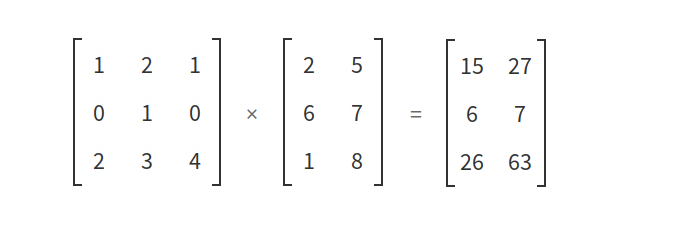

In [433]:
a = torch.tensor([[1,2,1],[0,1,0],[2,3,4]])
b = torch.tensor([[2,5],[6,7],[1,8]])
a,a.shape,b,b.shape

(tensor([[1, 2, 1],
         [0, 1, 0],
         [2, 3, 4]]),
 torch.Size([3, 3]),
 tensor([[2, 5],
         [6, 7],
         [1, 8]]),
 torch.Size([3, 2]))

In [434]:
torch.zeros(3,2)

tensor([[0., 0.],
        [0., 0.],
        [0., 0.]])

## **This is the most raw way of matrix multiplication**

In [435]:
result=torch.zeros(3,2)
for i in range(3):
    for j in range(2):
        for k in range(3):
            print((i,k),(k,j),(i,j))

(0, 0) (0, 0) (0, 0)
(0, 1) (1, 0) (0, 0)
(0, 2) (2, 0) (0, 0)
(0, 0) (0, 1) (0, 1)
(0, 1) (1, 1) (0, 1)
(0, 2) (2, 1) (0, 1)
(1, 0) (0, 0) (1, 0)
(1, 1) (1, 0) (1, 0)
(1, 2) (2, 0) (1, 0)
(1, 0) (0, 1) (1, 1)
(1, 1) (1, 1) (1, 1)
(1, 2) (2, 1) (1, 1)
(2, 0) (0, 0) (2, 0)
(2, 1) (1, 0) (2, 0)
(2, 2) (2, 0) (2, 0)
(2, 0) (0, 1) (2, 1)
(2, 1) (1, 1) (2, 1)
(2, 2) (2, 1) (2, 1)


This is what is going on above:  
`  a     b     r `   
`(i,k),(k,j),(i,j)`

In [436]:
%time
result=torch.zeros(3,2)
for i in range(3):
    for j in range(2):
        for k in range(3):
            result[i,j]+=a[i,k]*b[k,j]   
result            

CPU times: user 2 µs, sys: 1 µs, total: 3 µs
Wall time: 5.96 µs


tensor([[15., 27.],
        [ 6.,  7.],
        [26., 63.]])

In [437]:
def matmul(a,b):
    result=torch.zeros(3,2)
    ar,ac = a.shape # n_rows * n_cols
    br,bc = b.shape
    for i in range(ar):
        for j in range(bc):
            for k in range(ac):
                result[i,j]+=a[i,k]*b[k,j]   
    return result     
    

In [438]:
matmul(a,b)

tensor([[15., 27.],
        [ 6.,  7.],
        [26., 63.]])

## **Remove the innermost**

In [439]:
def matmul(a,b):
    
    ar,ac = a.shape # n_rows * n_cols
    br,bc = b.shape
    result=torch.zeros(ar, bc)
    for i in range(ar):
        for j in range(bc):            
            result[i,j]=(a[i,:]*b[:,j]).sum()
    return result     
    

In [440]:
matmul(a,b)

tensor([[15., 27.],
        [ 6.,  7.],
        [26., 63.]])

## **Broadcast**

**unsqueeze part changes the dimension for broadcasting**

In [441]:
a[i].shape,a[i].unsqueeze(-1).shape

(torch.Size([3]), torch.Size([3, 1]))

In [442]:
def matmul(a,b):    
    ar,ac = a.shape # n_rows * n_cols
    br,bc = b.shape
    result=torch.zeros(ar, bc)
    for i in range(ar):                   
            result[i]=(a[i].unsqueeze(-1)*b).sum(dim=0)
    return result     
    

In [443]:
matmul(a,b)

tensor([[15., 27.],
        [ 6.,  7.],
        [26., 63.]])

# **02_fully_connected.ipynb - Redo**

## **Dataset**

In [444]:
path=Path('mnist.pkl.gz')
with gzip.open(path) as f:
    x=pickle.load(f,encoding='latin-1')
x[0][0].shape,x[0][1].shape

((50000, 784), (50000,))

In [445]:
x[1][0].shape,x[1][1].shape

((10000, 784), (10000,))

test

In [446]:
x[2][0].shape

(10000, 784)

## **Get the data**

In [447]:
def get_data():
    path=Path('mnist.pkl.gz')
    with gzip.open(path) as f:
        #(x_train,train_y),(x_valid,valid_y) = f
        ((x_train,y_train),(x_valid,y_valid),_)=pickle.load(f,encoding='latin-1')
        return map(tensor, (x_train,y_train,x_valid,y_valid))
def normalize(x,m,s):
    return (x-m)/s

In [448]:
x_train,y_train,x_valid,y_valid=get_data()

In [449]:
x_train.mean(),x_train.std()

(tensor(0.1304), tensor(0.3073))

### **Normalize it**
___

In [450]:
train_mean,train_std =x_train.mean(),x_train.std()
train_mean,train_std

(tensor(0.1304), tensor(0.3073))

In [451]:
x_train = normalize(x_train,train_mean,train_std)

In [452]:
x_train.mean(),x_train.std()

(tensor(2.1325e-08), tensor(1.))

**now mean is close to 0 and deviation is 1**

In [453]:
x_valid.mean(),x_valid.std()

(tensor(0.1287), tensor(0.3050))

In [454]:
x_valid = normalize(x_valid, train_mean, train_std)

In [455]:
x_valid.mean(),x_valid.std()

(tensor(-0.0059), tensor(0.9924))

**Test the mean. (`x` must be a tensor**)

In [456]:
def test_near_zero(x,tolerance=1e-3):
    assert x.abs()<tolerance,f'near zero{a}'

In [457]:
x_train.mean()

tensor(2.1325e-08)

In [458]:
test_near_zero(x_train.mean(),tolerance=1e-3)

In [459]:
n,m = x_train.shape
c = train_y.max()+1
n,m,c

(50000, 784, tensor(10))

___

### **Create a linear layer and relu activation**

In [460]:
def lin(x,w,b):
    return x@w+b

In [461]:
def relu(x): return x.clamp_min(0.)

In [462]:
# num hidden
nh = 50

1. **Create random weighs with the same number of inputs (28*28) * (hidden activations)  for the first layer**
2. **for the second layer create weights as the same number hidden activation  * (number of outputs which is one**

### **Normalize the weights with standart xavier init**

In [463]:
w1 = torch.randn(m,nh)/math.sqrt(m)
b1 = torch.zeros(nh)
w2 = torch.rand(nh,1)/math.sqrt(m)
b2 = torch.zeros(1)

In [464]:
w1.mean(),w1.std()

(tensor(1.7029e-05), tensor(0.0357))

In [465]:
test_near_zero(w1.mean())
test_near_zero(w1.std()-1/math.sqrt(m))

In [466]:
x_valid.mean(),x_valid.std()

(tensor(-0.0059), tensor(0.9924))

**feed the valid to the linear layer**

In [467]:
t=lin(x_valid,w1,b1)

In [468]:
t.mean(),t.std()

(tensor(0.0574), tensor(0.9582))

In [469]:
t = relu(lin(x_valid,w1,b1))
t.mean(),t.std() 

(tensor(0.4069), tensor(0.5789))

### **Normalize the weights with Kaiming init**

Spot the difference `math.sqrt(2./m )` and the result is far better. 

In [470]:
# kaiming init / he init for relu
w1 = torch.randn(m,nh)*math.sqrt(2./m )
t1 = relu(lin(x_valid, w1, b1))
t1.mean(),t1.std()

(tensor(0.5719), tensor(0.8159))

## **Create the model**

In [471]:
def model(x):
    l1=lin(x,w1,b1)
    l2=relu(l1)
    l3=lin(l2,w2,b2)
    return l3

In [472]:
model(valid_x).squeeze(-1).shape

torch.Size([10000])

In [473]:
y_valid.shape

torch.Size([10000])

In [476]:
assert model(valid_x).squeeze(-1).shape == y_valid.shape

## **Create a MSE loss**

In [480]:
def mse(output,target):
    return ((output.squeeze(-1)-target).pow(2)).mean()

In [481]:
predictions= model(x_train)

In [483]:
loss=mse(predictions,y_train)
loss

tensor(23.7945)